In [81]:
import os
date_txt = r'training-split_2024-04-12-21-31'
path_data_dir = os.path.join('..', 'data', date_txt)
os.path.exists(path_data_dir)

True

In [82]:
path_train_dir = os.path.join(path_data_dir, 'train')
path_test_dir = os.path.join(path_data_dir, 'test')
os.path.exists(path_train_dir), os.path.exists(path_test_dir)

(True, True)

In [83]:
import torch.nn as nn
from torchvision import models
from torchvision.models import DenseNet121_Weights, DenseNet161_Weights, DenseNet169_Weights, DenseNet201_Weights

class CustomDenseNet(nn.Module):
    def __init__(self, version='densenet121', num_features=1024, embedding_dim=128, pretrained=True):
        super(CustomDenseNet, self).__init__()
        self.version = version
        self.model, num_features = self._get_densenet_model(version, pretrained)

        # Remove the original classifier
        self.model.classifier = nn.Identity()

        # New embedding layer to project features to the specified dimensions
        self.embedding = nn.Linear(num_features, embedding_dim)

        # Initially freeze all the pre-trained layers if pretrained is True
        if pretrained:
            self.freeze_pretrained()

    def _get_densenet_model(self, version, pretrained):
        models_dict = {
            'densenet121': (models.densenet121, DenseNet121_Weights.IMAGENET1K_V1, 1024),
            'densenet161': (models.densenet161, DenseNet161_Weights.IMAGENET1K_V1, 2208),
            'densenet169': (models.densenet169, DenseNet169_Weights.IMAGENET1K_V1, 1664),
            'densenet201': (models.densenet201, DenseNet201_Weights.IMAGENET1K_V1, 1920),
        }
        if version in models_dict:
            model_fn, weights, num_features = models_dict[version]
            if pretrained:
                model = model_fn(weights=weights)
            else:
                model = model_fn(weights=None)  # Load the model without pretrained weights
            return model, num_features
        else:
            raise ValueError(f"Unsupported DenseNet version: {version}. Supported versions are {list(models_dict.keys())}")

    def forward(self, x):
        x = self.model.features(x)
        x = nn.functional.gelu(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.embedding(x)
        return x

    def freeze_pretrained(self):
        # Freeze all parameters in the pre-trained model
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_all(self):
        # Unfreeze all parameters in the model for full training
        for param in self.model.parameters():
            param.requires_grad = True
        for param in self.embedding.parameters():
            param.requires_grad = True


In [84]:
import torch
import torch.nn as nn

# Assume CustomDenseNet is your model class
pretrained = True
model_version = 'densenet121'
model = CustomDenseNet(version=model_version, pretrained=pretrained)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
devices = [i for i in range(torch.cuda.device_count())]
device = devices[-1]
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"Using GPU: {device}")
    model.to(device)
else:
    print("Using CPU")
    model.to('cpu')


PyTorch Version: 2.0.1+cu117
CUDA Available: True
Device: 1
Using GPU: 1


In [85]:
import datetime

date_txt_now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')

model_root_dir = os.path.join('..', 'models', date_txt_now + '__' + date_txt + '__' + model_version + '__' + 'pretrained_' + str(pretrained))
if not os.path.exists(model_root_dir):
    print(f'Creating directory: {model_root_dir}')
    os.makedirs(model_root_dir)
model_path = os.path.join(model_root_dir, f'{model_version}.pth')
model_path

Creating directory: ..\models\2024-04-18-13-02__training-split_2024-04-12-21-31__densenet121__pretrained_True


'..\\models\\2024-04-18-13-02__training-split_2024-04-12-21-31__densenet121__pretrained_True\\densenet121.pth'

In [86]:
import os
import random
import logging
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class SunflowerStarDataset(Dataset):
    def __init__(self, root_dir, transform=None, verbosity=logging.INFO):
        """
        Args:
            root_dir (string): Directory with all the images divided into subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
            verbosity (int, optional): Logging level (e.g., logging.INFO, logging.DEBUG).
        """
        self.root_dir = root_dir
        self.transform = transform
        logging.basicConfig(level=verbosity)

        self.subdirectories = [os.path.join(root_dir, o) for o in os.listdir(root_dir)
                       if os.path.isdir(os.path.join(root_dir, o))]

        logging.debug(f"Found subdirectories: {self.subdirectories}")

        self.images_per_class = {}
        for subdir in self.subdirectories:
            images = [os.path.join(subdir, img) for img in os.listdir(subdir)]
            self.images_per_class[subdir] = images

        self.anchor_images = [img for sublist in self.images_per_class.values() for img in sublist]
        logging.info(f"Total anchor images found: {len(self.anchor_images)}")

    def __len__(self):
        return len(self.anchor_images)

    def __getitem__(self, idx):
        anchor_img_path = self.anchor_images[idx]
        positive_img_path = self._get_positive_sample(anchor_img_path)
        negative_img_path = self._get_negative_sample(anchor_img_path)

        if not os.path.exists(anchor_img_path):
            raise FileNotFoundError(f"Anchor image path does not exist: {anchor_img_path}")
        if not os.path.exists(positive_img_path):
            raise FileNotFoundError(f"Positive image path does not exist: {positive_img_path}")
        if not os.path.exists(negative_img_path):
            raise FileNotFoundError(f"Negative image path does not exist: {negative_img_path}")

        try:
            anchor_img = Image.open(anchor_img_path).convert("RGB")
            positive_img = Image.open(positive_img_path).convert("RGB")
            negative_img = Image.open(negative_img_path).convert("RGB")
        except FileNotFoundError as e:
            print(f"Error opening image: {e}")
            raise

        image_paths = [anchor_img_path, positive_img_path, negative_img_path]

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_img, positive_img, negative_img), image_paths


    def _get_positive_sample(self, anchor_img_path):
        same_class_dir = os.path.dirname(anchor_img_path)
        all_images = self.images_per_class[same_class_dir]
        positive_img_path = anchor_img_path

        if len(all_images) > 1:
            while positive_img_path == anchor_img_path:
                positive_img_path = random.choice(all_images)
        logging.debug(f"Selected positive image path: {positive_img_path}")
        return positive_img_path

    def _get_negative_sample(self, anchor_img_path):
        """Returns a path to a negative sample, i.e., an image of a different individual."""
        different_class_dir = random.choice(self.subdirectories)
        # Ensure the selected directory is not the same as the anchor's and is not empty
        while os.path.dirname(anchor_img_path) == different_class_dir or not self.images_per_class[different_class_dir]:
            different_class_dir = random.choice(self.subdirectories)

        # Once a valid directory with images is found, choose an image from it
        all_images = self.images_per_class[different_class_dir]
        negative_img_path = os.path.join(different_class_dir, os.path.basename(random.choice(all_images)))

        # Ensure the path is absolute to prevent issues
        negative_img_path = os.path.abspath(negative_img_path)
        logging.debug(f"Constructed negative path: {negative_img_path}")  # Debugging output
        return negative_img_path




In [87]:
import numpy as np
import cv2
from torchvision.transforms import functional as F

class RandomPad(object):
    def __init__(self, max_pad, fill=0, padding_mode='constant'):
        assert isinstance(max_pad, (int, tuple))
        if isinstance(max_pad, int):
            self.max_pad = (max_pad, max_pad)
        else:
            assert len(max_pad) == 2, "max_pad should be int or 2-tuple"
            self.max_pad = max_pad

        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        padding = tuple(random.randint(0, max_pad) for max_pad in self.max_pad)
        return F.pad(img, padding, self.fill, self.padding_mode)

    def __repr__(self):
        return self.__class__.__name__ + '(max_pad={0}, fill={1}, padding_mode={2})'.\
            format(self.max_pad, self.fill, self.padding_mode)

class RandomSolarize(object):
    def __init__(self, threshold_range, p=0.5):
        assert isinstance(threshold_range, tuple) and len(threshold_range) == 2
        self.threshold_range = threshold_range
        self.p = p

    def __call__(self, img):
        threshold = random.uniform(*self.threshold_range)
        return F.solarize(img, threshold) if random.random() < self.p else img

    def __repr__(self):
        return self.__class__.__name__ + '(threshold_range={0}, p={1})'.\
            format(self.threshold_range, self.p)

class RandomOrderTransforms(object):
    def __init__(self, transforms, probs=None, list_prob=1.0):
        self.transforms = transforms
        if probs is None:
            self.probs = [1.0] * len(transforms)
        else:
            self.probs = probs
        self.list_prob = list_prob

    def __call__(self, img):
        if random.random() < self.list_prob:
            order = list(range(len(self.transforms)))
            random.shuffle(order)
            for i in order:
                if random.random() < self.probs[i]:
                    img = self.transforms[i](img)
        return img

class RandomGaussianBlur(object):
    def __init__(self, kernel_size_range, sigma=(0.1, 2.0), p=0.5):
        assert isinstance(kernel_size_range, tuple) and len(kernel_size_range) == 2, \
            "kernel_size_range should be a tuple (min_size, max_size)"
        self.kernel_size_range = kernel_size_range
        self.sigma = sigma
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            # Select a random kernel size within the range
            kernel_size = random.choice(range(self.kernel_size_range[0], self.kernel_size_range[1] + 1, 2))
            # Ensure the kernel size is always an odd number (required for the Gaussian blur operation)
            if kernel_size % 2 == 0:
                kernel_size += 1
            sigma = random.uniform(*self.sigma)
            return F.gaussian_blur(img, kernel_size, [sigma, sigma])
        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(kernel_size_range={self.kernel_size_range}, sigma={self.sigma}, p={self.p})"

class RandomColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0, p=0.5):
        self.transform = transforms.ColorJitter(brightness, contrast, saturation, hue)
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.transform(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(brightness={0}, contrast={1}, saturation={2}, hue={3}, p={4})'.\
            format(self.transform.brightness, self.transform.contrast,
                   self.transform.saturation, self.transform.hue, self.p)

class LensDistortion:
    def __init__(self, k1_range=(-0.1, 0.1), k2_range=(-0.005, 0.005),
                 p1_range=(-0.005, 0.005), p2_range=(-0.005, 0.005), p=1):
        self.k1_range = k1_range
        self.k2_range = k2_range
        self.p1_range = p1_range
        self.p2_range = p2_range
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            h, w = img.size

            # Generate random distortion coefficients
            k1 = random.uniform(*self.k1_range)
            k2 = random.uniform(*self.k2_range)
            p1 = random.uniform(*self.p1_range)
            p2 = random.uniform(*self.p2_range)

            # Prepare distortion matrix
            mtx = np.array([[w/2.0, 0.0, w/2.0], [0.0, h/2.0, h/2.0], [0.0, 0.0, 1.0]])
            dist = np.array([k1, k2, p1, p2, 0.0], dtype=np.float32)

            # Apply distortion
            img = cv2.undistort(np.array(img), mtx, dist, None, mtx)
            img = Image.fromarray(img)

        return img

class RandomProportionalCrop:
    def __init__(self, scale_range=(0.8, 1.0), aspect_ratio_range=(3/4, 4/3)):
        self.scale_range = scale_range
        self.aspect_ratio_range = aspect_ratio_range

    def __call__(self, img):
        width, height = img.size
        aspect_ratio = random.uniform(*self.aspect_ratio_range)
        scale = random.uniform(*self.scale_range)

        if random.random() < 0.5:
            new_width = int(scale * width)
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = int(scale * height)
            new_width = int(new_height * aspect_ratio)

        if new_width > width:
            new_width = width
        if new_height > height:
            new_height = height

        left = random.randint(0, width - new_width)
        top = random.randint(0, height - new_height)

        return img.crop((left, top, left + new_width, top + new_height))

class CustomRandomErasing(object):
    def __init__(self, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0):
        self.p = p
        self.scale = scale
        self.ratio = ratio
        self.value = value

    def __call__(self, img):
        if random.uniform(0, 1) > self.p:
            return img

        img_np = np.array(img)
        h, w, _ = img_np.shape

        while True:
            area = h * w * random.uniform(self.scale[0], self.scale[1])
            aspect_ratio = random.uniform(self.ratio[0], self.ratio[1])

            erasing_h = int(np.sqrt(area / aspect_ratio))
            if erasing_h < h:
                erasing_w = int(np.sqrt(area * aspect_ratio))
                if erasing_w < w:
                    break

        top = random.randint(0, h - erasing_h)
        left = random.randint(0, w - erasing_w)

        if img_np.shape[2] == 3:
            img_np[top:top + erasing_h, left:left + erasing_w, :] = self.value
        else:
            img_np[top:top + erasing_h, left:left + erasing_w] = self.value

        return Image.fromarray(img_np)

In [88]:
h, w = 256, 256
# You should separate the transforms that can be randomly ordered
# and the ones that should always be at the end
#rh, rw = 300, 300
random_order_transforms = [
    RandomPad(max_pad=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
   # transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
  #  transforms.RandomPerspective(distortion_scale=0.5, p=1),
    RandomGaussianBlur(kernel_size_range=(3, 5), sigma=(0.1, 0.5), p=1),
    #RandomColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1, p=1),
    #RandomSolarize((.7, .95), p=1),
 #   LensDistortion(k1_range=(-0.2, 0.2), k2_range=(-0.05, 0.05),
 #                                          p1_range=(-0.1, 0.1), p2_range=(-0.1, 0.1), p=1),
    RandomProportionalCrop(scale_range=(0.5, 1), aspect_ratio_range=(3/4, 4/3)),
  #  CustomRandomErasing(p=1, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
]

always_end_transforms = [
    transforms.Resize((h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

transform_probs = [
    .5, # RandomPad
    .5, # RandomHorizontalFlip
    .5, # RandomVerticalFlip
    .5, # RandomRotation
   # .2, # RandomAffine
   # .2, # RandomPerspective
    .5, # RandomGaussianBlur
    #.2, # RandomColorJitter
    #.2, # RandomSolarize
  #  .2, # LensDistortion
    .5, # RandomProportionalCrop
  #  .2, # RandomErasing
]

list_prob = 1  # 90% chance to apply the list of random transforms

transform_train_list = [
    RandomOrderTransforms(random_order_transforms, transform_probs, list_prob),
] + always_end_transforms

transform_test_list = [
    RandomOrderTransforms(random_order_transforms, transform_probs, list_prob),
] + always_end_transforms

In [89]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataset = SunflowerStarDataset(root_dir=path_train_dir, transform=transforms.Compose(transform_train_list))
test_dataset = SunflowerStarDataset(root_dir=path_test_dir, transform=transforms.Compose(transform_test_list))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) ## hanging error with num_workers > 0
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

INFO:root:Total anchor images found: 5160
INFO:root:Total anchor images found: 1457


In [90]:
from tqdm import tqdm

unique_ids = []

pbar = tqdm(total=len(train_dataloader), desc='Batches', position=0, leave=True)
for batch_idx, (images, image_paths) in enumerate(train_dataloader):
    anchor, positive, negative = images
    for i in range(batch_size):
        anchor_path = image_paths[0][i]
        positive_path = image_paths[1][i]
        negative_path = image_paths[2][i]

        anchor_id = os.path.basename(os.path.dirname(anchor_path))
        positive_id = os.path.basename(os.path.dirname(positive_path))
        negative_id = os.path.basename(os.path.dirname(negative_path))

        unique_ids.extend([anchor_id, positive_id, negative_id])

    pbar.update(1)
pbar.close()

unique_ids = sorted(list(set(unique_ids)))
print(f"Unique IDs: {unique_ids}")
print(f'Number of unique IDs: {len(unique_ids)}')

Batches: 100%|██████████| 645/645 [04:00<00:00,  2.68it/s]

Unique IDs: ['0001__PWS_2023', '0002__PWS_2023', '0003__PWS_2023', '0004__PWS_2023', '0005__PWS_2023', '0006__PWS_2023', '0007__PWS_2023', '0008__PWS_2023', '0009__PWS_2023', '0010__PWS_2023', '0011__PWS_2023', '0012__PWS_2023', '0013__PWS_2023', '0014__PWS_2023', '0015__PWS_2023', '0016__PWS_2023', '0017__PWS_2023', '0018__PWS_2023', '0019__PWS_2023', '0020__PWS_2023', '0021__PWS_2023', '0022__PWS_2023', '0023__PWS_2023', '0024__PWS_2023', '0025__PWS_2023', '0026__PWS_2023', '0027__PWS_2023', '0028__PWS_2023', '0029__PWS_2023', '0030__PWS_2023', '0031__PWS_2023', '0032__PWS_2023', '0033__PWS_2023', '0034__PWS_2023', '0035__PWS_2023', '0036__PWS_2023', '0037__PWS_2023', '0038__PWS_2023', '0039__PWS_2023', '0040__PWS_2023', '0041__PWS_2023', '0042__PWS_2023', '0043__PWS_2023', '0044__PWS_2023', '0045__PWS_2023', '0046__PWS_2023', '0047__PWS_2023', '0048__PWS_2023', '0049__PWS_2023', '0050__PWS_2023', '0051__PWS_2023', '0052__PWS_2023', '0053__PWS_2023', '0054__PWS_2023', '0055__PWS_2023

In [91]:
path_fig_dir = os.path.join(model_root_dir, f'{model_version}_figures')
if not os.path.exists(path_fig_dir):
    print(f'Creating directory: {path_fig_dir}')
    os.makedirs(path_fig_dir)

Creating directory: ..\models\2024-04-18-13-02__training-split_2024-04-12-21-31__densenet121__pretrained_True\densenet121_figures


C:\Users\wlwee\AppData\Local\Temp\ipykernel_11276\1192451116.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_string, n)


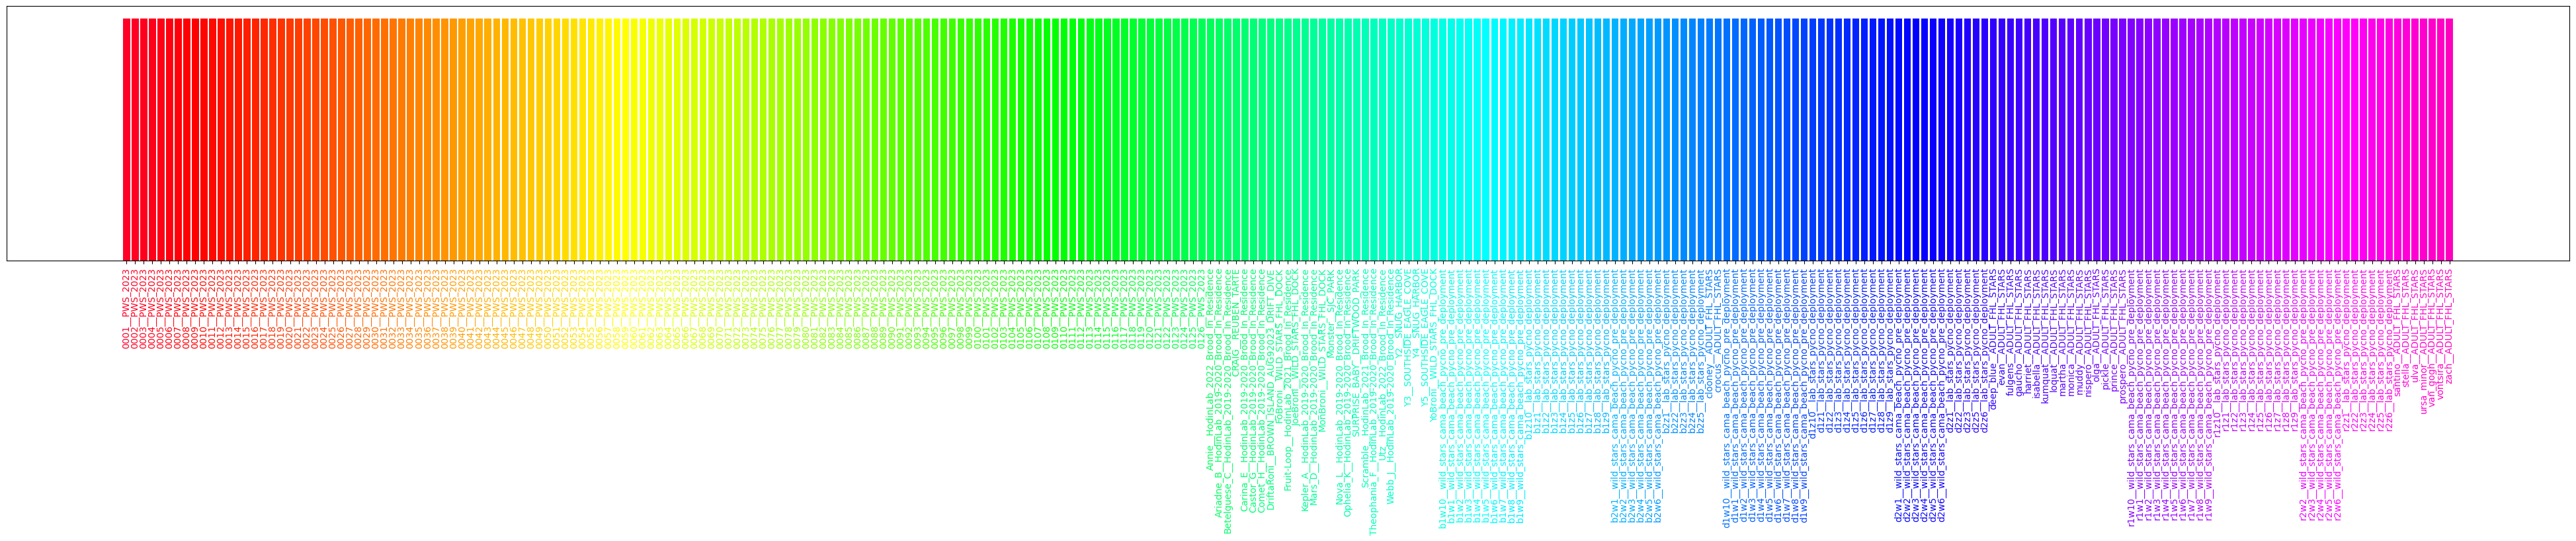

In [92]:
## get continuous colormap for unique_ids

import matplotlib.pyplot as plt

n = len(unique_ids)
cmap_string = 'gist_rainbow'
cmap = plt.cm.get_cmap(cmap_string, n)

fig, ax = plt.subplots(1, 1, figsize= (50, 5))

xticks = range(n)
xlabs = unique_ids

id_color_dict = {uid: cmap(i) for i, uid in enumerate(unique_ids)}

for i, uid in enumerate(unique_ids):
    ax.bar(i, .1, color=cmap(i), label=uid)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabs, rotation=90)
## set xtick color to be the same as the bar color
for i, (label, color) in enumerate(zip(ax.get_xticklabels(), [cmap(i) for i in xticks])):
    label.set_color(color)

ax.set_yticks([])

path_fig = os.path.join(path_fig_dir, 'unique_ids.png')
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show()
plt.close()



torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
Anchor: d2z6__lab_stars_pycno_deployment, Positive: d2z6__lab_stars_pycno_deployment, Negative: 0081__PWS_2023
Anchor: b2z3__lab_stars_pycno_deployment, Positive: b2z3__lab_stars_pycno_deployment, Negative: d1w7__wild_stars_cama_beach_pycno_pre_deployment
Anchor: b1z8__lab_stars_pycno_deployment, Positive: b1z8__lab_stars_pycno_deployment, Negative: 0085__PWS_2023
Anchor: b1z9__lab_stars_pycno_deployment, Positive: b1z9__lab_stars_pycno_deployment, Negative: 0066__PWS_2023
Anchor: d2z5__lab_stars_pycno_deployment, Positive: d2z5__lab_stars_pycno_deployment, Negative: 0007__PWS_2023
Anchor: 0046__PWS_2023, Positive: 0046__PWS_2023, Negative: d1w2__wild_stars_cama_beach_pycno_pre_deployment
Anchor: d2w2__wild_stars_cama_beach_pycno_pre_deployment, Positive: d2w2__wild_stars_cama_beach_pycno_pre_deployment, Negative: r1w6__wild_stars_cama_beach_pycno_pre_deployment
Anchor: 0065__PWS_2023, Positive: 0065

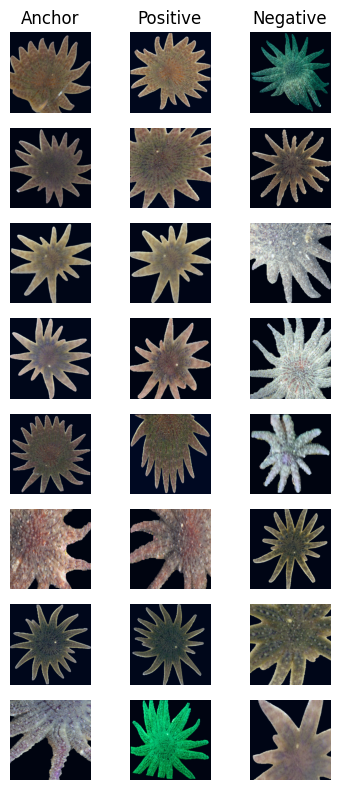

In [93]:
import matplotlib.pyplot as plt

def get_id_code (image_path):
    return os.path.basename(os.path.dirname(image_path))

image_titles = ['Anchor', 'Positive', 'Negative']

path_figure = os.path.join(path_fig_dir, 'triplet_example.png')
dpi = 300

for batch_idx, (images, image_paths) in enumerate(train_dataloader):
  anchor, positive, negative = images
  print(anchor.shape, positive.shape, negative.shape)

  fig, axs = plt.subplots(batch_size, 3, figsize=(4, batch_size))

  for i in range(batch_size):
    images = [anchor[i], positive[i], negative[i]]
    images = [img.permute(1, 2, 0) for img in images]
    images = [img.cpu().numpy() for img in images]
    ## normalize the images
    images = [(img - img.min()) / (img.max() - img.min()) for img in images]

    anchor_path = image_paths[0][i]
    positive_path = image_paths[1][i]
    negative_path = image_paths[2][i]

    anchor_id = get_id_code(anchor_path)
    positive_id = get_id_code(positive_path)
    negative_id = get_id_code(negative_path)

    print(f'Anchor: {anchor_id}, Positive: {positive_id}, Negative: {negative_id}')
    if anchor_id != positive_id:
        print(f'ERROR in positive pair: Anchor: {anchor_id}, Positive: {positive_id}')

    for j in range(3):
      ax = axs[i][j]
      ax.imshow(images[j])
      if i == 0:
        ax.set_title(image_titles[j])
      ax.axis('off')

  fig.tight_layout()

  fig.savefig(path_figure, dpi=dpi, bbox_inches='tight')

  plt.show()
  plt.close()

  break

In [94]:
batch_size = 32
train_dataset = SunflowerStarDataset(root_dir=path_train_dir, transform=transforms.Compose(transform_train_list), verbosity=logging.disable)
test_dataset = SunflowerStarDataset(root_dir=path_test_dir, transform=transforms.Compose(transform_test_list), verbosity=logging.disable)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) ## hanging error with num_workers > 0
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

INFO:root:Total anchor images found: 5160
INFO:root:Total anchor images found: 1457


In [95]:
import matplotlib.pyplot as plt
import os

# Function to compute simple moving average
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'valid')

# Visualize train and test losses with running average
def visualize_losses(train_losses, test_losses, batch_size, path_fig):
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    # Train Loss Plot
    ax = axs[0]
    ax.plot(train_losses, label='Train Loss', zorder=1, linewidth=0.5, alpha=0.5)  # Original losses
    train_ma = moving_average(train_losses, batch_size)  # Moving average
    ax.plot(range(batch_size - 1, len(train_losses)), train_ma, label='Train Loss MA', zorder=2, linewidth=1, color='green')  # Offset x to match the length of MA
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.legend()

    # Test Loss Plot
    ax = axs[1]
    ax.plot(test_losses, label='Test Loss', zorder=1, linewidth=0.5, alpha=0.5)  # Original losses
    test_ma = moving_average(test_losses, batch_size)  # Moving average
    ax.plot(range(batch_size - 1, len(test_losses)), test_ma, label='Test Loss MA', zorder=2, linewidth=1, color='red')  # Offset x to match the length of MA
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.legend()

    # Combined Loss Plot
    ax = axs[2]
    ax.plot(range(batch_size - 1, len(train_losses)), train_ma, label='Train Loss MA', zorder=2, linewidth=1, color='green')
    ax.plot(range(batch_size - 1, len(test_losses)), test_ma, label='Test Loss MA', zorder=2, linewidth=1, color='red')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.legend()

    fig.savefig(path_fig, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

In [96]:
def visualize_test_anchor_outputs_w_pca (path_fig, test_anchor_outputs, test_anchor_colors):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    pca = PCA(n_components=n_components)
    test_anchor_outputs = torch.cat(test_anchor_outputs, dim=0).cpu().numpy()
    pca.fit(test_anchor_outputs)
    pcs = pca.transform(test_anchor_outputs)
    pc0, pc1 = pcs[:, 0], pcs[:, 1]
    ax.scatter(pc0, pc1, c=test_anchor_colors, s=1, alpha=0.5)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    fig.savefig(path_fig, dpi=300, bbox_inches='tight')
    plt.close()

In [97]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the triplet loss
margin = 1 # Margin for triplet loss
triplet_loss = nn.TripletMarginLoss(margin=margin)
update_margin_every_n_epochs = 20
margin_step = 0.1
max_margin = 1

# Define the optimizer
pre_unfreeze_lr = 0.01  # Learning rate before unfreezing
post_unfreeze_lr = 0.001  # Learning rate after unfreezing
optimizer = optim.Adam(model.parameters(), lr=pre_unfreeze_lr)

# Define the scheduler
step_size = 5  # Step size for the scheduler
gamma = 0.5  # Gamma for the scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Adjusts the learning rate

path_best_model = os.path.join(model_root_dir, f'{model_version}_best.pth')
path_current_model = os.path.join(model_root_dir, f'{model_version}_current.pth')

# Initialize the TensorBoard writer
log_dir = os.path.join(model_root_dir, 'logs')
if not os.path.exists(log_dir):
    print(f'Creating directory: {log_dir}')
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)

best_loss = float('inf')

num_epochs = 200
unfreeze_epoch = 5
train_losses = []
test_losses = []

batch_readout_rate = 10 ## even numbers expected
batch_readout = False

nbatches_train = len(train_dataloader)
nbatches_test = len(test_dataloader)

previous_loss = None
current_loss = None

early_stopping_counter = 0
early_stopping_threshold = 5

## fit PCA to anchor_output, positive_output pairs
from sklearn.decomposition import PCA
n_components = 2
path_pc_dir = os.path.join(path_fig_dir, 'pca_evolution')
if not os.path.exists(path_pc_dir):
    print(f'Creating directory: {path_pc_dir}')
    os.makedirs(path_pc_dir)

pbar = tqdm(total=num_epochs, desc='Epochs', position=0, leave=True)
for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        print(f"Unfreezing all layers at epoch {epoch}")
        model.unfreeze_all()
        optimizer = optim.Adam(model.parameters(), lr=post_unfreeze_lr)
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Adjusts the learning rate
        print(f"Changed optimizer to Adam with lr={post_unfreeze_lr}")

    train_loss = 0

    # Update margin
    if (epoch + 1) % update_margin_every_n_epochs == 0:
        new_margin = triplet_loss.margin + margin_step
        if new_margin <= max_margin:
            triplet_loss = nn.TripletMarginLoss(margin=new_margin)
            print(f"Updated margin to {new_margin} at epoch {epoch+1}")

    model.train()
    for batch_idx, (images, image_paths) in enumerate(train_dataloader):
        anchor, positive, negative = images
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad() # Zero the gradients

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        train_losses.append(loss.item())

        train_loss += loss.item()

        loss.backward() # Compute the gradients
        optimizer.step() # Update the weights
        scheduler.step() # Update the learning rate

        # Optionally log histograms every few batches or just per epoch
        if batch_idx % 50 == 0:  # Adjust this condition to control frequency
            for name, param in model.named_parameters():
                writer.add_histogram(f'Parameters/{name}', param, epoch * len(train_dataloader) + batch_idx)
                if param.grad is not None:
                    writer.add_histogram(f'Gradients/{name}', param.grad, epoch * len(train_dataloader) + batch_idx)

        if batch_idx % batch_readout_rate == 0 and batch_readout:
            print(f"TRAIN: Epoch {epoch}|{num_epochs}, Batch {batch_idx}|{nbatches_train}, Loss: {loss.item()}")

    # At the end of each epoch, log histograms again to capture end-of-epoch status
    for name, param in model.named_parameters():
        writer.add_histogram(f'Parameters/{name}', param, epoch * len(train_dataloader) + len(train_dataloader))
        if param.grad is not None:
            writer.add_histogram(f'Gradients/{name}', param.grad, epoch * len(train_dataloader) + len(train_dataloader))

    train_loss /= nbatches_train

    ## stores test anchor_output for visualization
    test_anchor_outputs = []
    test_anchor_colors = []

    eval_loss = 0

    # test the model
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, image_paths) in enumerate(test_dataloader):
            anchor, positive, negative = images
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            test_anchor_outputs.append(anchor_output)
            anchor_ids = [os.path.basename(os.path.dirname(image_path)) for image_path in image_paths[0]]
            test_anchor_colors.extend([id_color_dict[anchor_id] for anchor_id in anchor_ids])

            loss = triplet_loss(anchor_output, positive_output, negative_output)

            eval_loss += loss.item()

            test_losses.append(loss.item())
            if batch_idx % batch_readout_rate == 0 and batch_readout:
                print(f"TEST: Epoch {epoch}|{num_epochs}, Batch {batch_idx}|{nbatches_test}, Loss: {loss.item()}")

    eval_loss /= nbatches_test
    current_loss = eval_loss
    print(f"Epoch {epoch}|{num_epochs}, Test Loss: {eval_loss} | Train Loss: {train_loss}")
    if current_loss < best_loss:
        best_loss = current_loss
        torch.save(model.state_dict(), path_best_model)

    if previous_loss is not None:
        if current_loss > previous_loss:
                early_stopping_counter += 1
        else:
            early_stopping_counter = 0

    if early_stopping_counter >= early_stopping_threshold:
        print(f"Early stopping at epoch {epoch}")
        break

    ## visualize test anchor_output, positive_output pairs
    path_fig = os.path.join(path_pc_dir, f'epoch_{epoch}.png')
    visualize_test_anchor_outputs_w_pca(path_fig, test_anchor_outputs, test_anchor_colors)

    ## visualize train and test losses
    path_fig = os.path.join(path_fig_dir, 'losses.png')
    visualize_losses(train_losses, test_losses, batch_size, path_fig)

    torch.save(model.state_dict(), path_current_model)

    previous_loss = current_loss

    pbar.update(1)
pbar.close()

# Close the writer after training is finished
writer.close()

Creating directory: ..\models\2024-04-18-13-02__training-split_2024-04-12-21-31__densenet121__pretrained_True\logs
Creating directory: ..\models\2024-04-18-13-02__training-split_2024-04-12-21-31__densenet121__pretrained_True\densenet121_figures\pca_evolution


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0|200, Test Loss: 0.3988308867682581 | Train Loss: 0.2761859660163338


Epochs:   0%|          | 1/200 [06:20<21:01:31, 380.36s/it]

Epoch 1|200, Test Loss: 0.34999493865863135 | Train Loss: 0.2701429279498112


Epochs:   1%|          | 2/200 [12:38<20:50:33, 378.96s/it]

Epoch 2|200, Test Loss: 0.3334672723127448 | Train Loss: 0.29462610497886754


Epochs:   2%|▏         | 3/200 [18:53<20:38:38, 377.25s/it]

Epoch 3|200, Test Loss: 0.3153118549481682 | Train Loss: 0.29299235031192683


Epochs:   2%|▏         | 4/200 [25:06<20:26:22, 375.42s/it]

Epoch 4|200, Test Loss: 0.332380266941112 | Train Loss: 0.2749863507938974


Epochs:   2%|▎         | 5/200 [31:14<20:12:17, 373.01s/it]

Unfreezing all layers at epoch 5
Changed optimizer to Adam with lr=0.001
Epoch 5|200, Test Loss: 0.5753404903023139 | Train Loss: 0.42095866744165067


Epochs:   3%|▎         | 6/200 [37:41<20:21:29, 377.78s/it]

Epoch 6|200, Test Loss: 0.5190163556000461 | Train Loss: 0.4010981676387198


Epochs:   4%|▎         | 7/200 [44:06<20:22:27, 380.04s/it]

Epoch 7|200, Test Loss: 0.47746940151504846 | Train Loss: 0.39279421142957827


Epochs:   4%|▍         | 8/200 [50:31<20:21:18, 381.66s/it]

Epoch 8|200, Test Loss: 0.47225627011579013 | Train Loss: 0.36161881234542825


Epochs:   4%|▍         | 9/200 [56:53<20:15:03, 381.70s/it]

Epoch 9|200, Test Loss: 0.4520026860029801 | Train Loss: 0.3671580656995008


Epochs:   5%|▌         | 10/200 [1:03:16<20:09:38, 381.99s/it]

Epoch 10|200, Test Loss: 0.5321578402882037 | Train Loss: 0.3601578359986529


Epochs:   6%|▌         | 11/200 [1:09:39<20:04:38, 382.43s/it]

Epoch 11|200, Test Loss: 0.3771717797802842 | Train Loss: 0.38670661447592725


Epochs:   6%|▌         | 12/200 [1:16:00<19:56:44, 381.94s/it]

Epoch 12|200, Test Loss: 0.3971689803444821 | Train Loss: 0.37819172184408445


Epochs:   6%|▋         | 13/200 [1:22:22<19:50:09, 381.87s/it]

Epoch 13|200, Test Loss: 0.4344586072408635 | Train Loss: 0.3707973660878193


Epochs:   7%|▋         | 14/200 [1:28:37<19:38:04, 380.03s/it]

Epoch 14|200, Test Loss: 0.5557326340804929 | Train Loss: 0.38967885159783894


Epochs:   8%|▊         | 15/200 [1:34:54<19:28:53, 379.10s/it]

Epoch 15|200, Test Loss: 0.4686480592126432 | Train Loss: 0.39111198319329155


Epochs:   8%|▊         | 16/200 [1:41:10<19:19:37, 378.14s/it]

Epoch 16|200, Test Loss: 0.42756315677062323 | Train Loss: 0.34280784409723164


Epochs:   8%|▊         | 17/200 [1:47:30<19:14:50, 378.63s/it]

Epoch 17|200, Test Loss: 0.5392105245719785 | Train Loss: 0.37132346666889426


Epochs:   9%|▉         | 18/200 [1:53:49<19:08:37, 378.67s/it]

Epoch 18|200, Test Loss: 0.441261335235575 | Train Loss: 0.3671166296174497


Epochs:  10%|▉         | 19/200 [2:00:08<19:02:26, 378.71s/it]

Epoch 19|200, Test Loss: 0.481270218996898 | Train Loss: 0.38934282351423194


Epochs:  10%|█         | 20/200 [2:06:26<18:55:53, 378.63s/it]

Epoch 20|200, Test Loss: 0.48940527665874234 | Train Loss: 0.39487690533752795


Epochs:  10%|█         | 21/200 [2:12:39<18:44:55, 377.07s/it]

Epoch 21|200, Test Loss: 0.5531414575550867 | Train Loss: 0.3714513309575893


Epochs:  11%|█         | 22/200 [2:18:57<18:38:42, 377.09s/it]

Epoch 22|200, Test Loss: 0.47285297836946405 | Train Loss: 0.3661151922963284


Epochs:  12%|█▏        | 23/200 [2:25:12<18:31:11, 376.68s/it]

Epoch 23|200, Test Loss: 0.47046046833629196 | Train Loss: 0.35349426243776155


Epochs:  12%|█▏        | 24/200 [2:31:26<18:22:18, 375.79s/it]

Epoch 24|200, Test Loss: 0.5338871168053668 | Train Loss: 0.3560457038290707


Epochs:  12%|█▎        | 25/200 [2:37:39<18:13:17, 374.85s/it]

Epoch 25|200, Test Loss: 0.5085503128559693 | Train Loss: 0.3963656253468843


Epochs:  13%|█▎        | 26/200 [2:43:45<17:59:25, 372.22s/it]

Epoch 26|200, Test Loss: 0.47461687190377194 | Train Loss: 0.39251586454518045


Epochs:  14%|█▎        | 27/200 [2:49:54<17:51:02, 371.46s/it]

Epoch 27|200, Test Loss: 0.5185910243055095 | Train Loss: 0.40962110708157223


Epochs:  14%|█▍        | 28/200 [2:56:05<17:44:04, 371.19s/it]

Epoch 28|200, Test Loss: 0.4500033246434253 | Train Loss: 0.3753768025357046


Epochs:  14%|█▍        | 29/200 [3:02:11<17:33:50, 369.77s/it]

Epoch 29|200, Test Loss: 0.38461019617059955 | Train Loss: 0.36181461424739275


Epochs:  15%|█▌        | 30/200 [3:08:22<17:28:11, 369.95s/it]

Epoch 30|200, Test Loss: 0.4721423675832541 | Train Loss: 0.405039243032167


Epochs:  16%|█▌        | 31/200 [3:14:28<17:18:40, 368.76s/it]

Epoch 31|200, Test Loss: 0.4669629869901616 | Train Loss: 0.3917081970491527


Epochs:  16%|█▌        | 32/200 [3:20:36<17:11:42, 368.47s/it]

Epoch 32|200, Test Loss: 0.5167964123513388 | Train Loss: 0.4106255323614603


Epochs:  16%|█▋        | 33/200 [3:26:38<17:00:45, 366.74s/it]

Epoch 33|200, Test Loss: 0.48473843867364136 | Train Loss: 0.4184611240102921


Epochs:  17%|█▋        | 34/200 [3:32:45<16:54:34, 366.71s/it]

Epoch 34|200, Test Loss: 0.46438766659601877 | Train Loss: 0.36617510287482063


Epochs:  18%|█▊        | 35/200 [3:38:48<16:45:27, 365.62s/it]

Epoch 35|200, Test Loss: 0.4626287247823632 | Train Loss: 0.38109261772514863


Epochs:  18%|█▊        | 36/200 [3:44:53<16:38:31, 365.31s/it]

Epoch 36|200, Test Loss: 0.5559357796674189 | Train Loss: 0.4063938993178768


Epochs:  18%|█▊        | 37/200 [3:50:56<16:31:02, 364.80s/it]

Epoch 37|200, Test Loss: 0.514395110309124 | Train Loss: 0.3848921915079341


Epochs:  19%|█▉        | 38/200 [3:56:59<16:23:38, 364.31s/it]

Epoch 38|200, Test Loss: 0.4772031857915547 | Train Loss: 0.3684587933950954


Epochs:  20%|█▉        | 39/200 [4:03:04<16:17:52, 364.43s/it]

Epoch 39|200, Test Loss: 0.538795833354411 | Train Loss: 0.3358396526288103


Epochs:  20%|██        | 40/200 [4:09:07<16:10:18, 363.86s/it]

Epoch 40|200, Test Loss: 0.47559096081101376 | Train Loss: 0.40396379007969374


Epochs:  20%|██        | 41/200 [4:15:09<16:02:49, 363.33s/it]

Epoch 41|200, Test Loss: 0.4731748764929564 | Train Loss: 0.34031642145580715


Epochs:  21%|██        | 42/200 [4:21:14<15:57:53, 363.75s/it]

Epoch 42|200, Test Loss: 0.44856515105651773 | Train Loss: 0.39510915768735205


Epochs:  22%|██▏       | 43/200 [4:27:17<15:51:33, 363.65s/it]

Epoch 43|200, Test Loss: 0.4574346056450968 | Train Loss: 0.3647494497306553


Epochs:  22%|██▏       | 44/200 [4:33:20<15:44:55, 363.43s/it]

Epoch 44|200, Test Loss: 0.4705188125371933 | Train Loss: 0.40607693202701617


Epochs:  22%|██▎       | 45/200 [4:39:21<15:37:28, 362.89s/it]

Epoch 45|200, Test Loss: 0.4878469119253366 | Train Loss: 0.3838619441713816


Epochs:  23%|██▎       | 46/200 [4:45:24<15:31:12, 362.81s/it]

Epoch 46|200, Test Loss: 0.5128276017696961 | Train Loss: 0.4260416687638671


Epochs:  24%|██▎       | 47/200 [4:51:27<15:24:53, 362.70s/it]

Epoch 47|200, Test Loss: 0.456455502173175 | Train Loss: 0.3989884444960841


Epochs:  24%|██▍       | 48/200 [4:57:30<15:19:13, 362.85s/it]

Epoch 48|200, Test Loss: 0.4352696152484935 | Train Loss: 0.35783306858789776


Epochs:  24%|██▍       | 49/200 [5:03:33<15:13:48, 363.10s/it]

Epoch 49|200, Test Loss: 0.4311644732952118 | Train Loss: 0.4308983643113831


Epochs:  25%|██▌       | 50/200 [5:09:35<15:06:36, 362.65s/it]

Epoch 50|200, Test Loss: 0.543290095484775 | Train Loss: 0.34719872952979286


Epochs:  26%|██▌       | 51/200 [5:15:36<14:59:41, 362.29s/it]

Epoch 51|200, Test Loss: 0.503102698403856 | Train Loss: 0.3994191421402825


Epochs:  26%|██▌       | 52/200 [5:21:37<14:52:27, 361.80s/it]

Epoch 52|200, Test Loss: 0.49715809459271637 | Train Loss: 0.3946560525599821


Epochs:  26%|██▋       | 53/200 [5:27:38<14:45:58, 361.62s/it]

Epoch 53|200, Test Loss: 0.4765066731235255 | Train Loss: 0.37694881828846755


Epochs:  27%|██▋       | 54/200 [5:33:39<14:39:27, 361.42s/it]

Epoch 54|200, Test Loss: 0.5170396352591722 | Train Loss: 0.39231175083069153


Epochs:  28%|██▊       | 55/200 [5:39:41<14:33:27, 361.43s/it]

Epoch 55|200, Test Loss: 0.4413700975153757 | Train Loss: 0.3872893295354313


Epochs:  28%|██▊       | 56/200 [5:45:41<14:26:43, 361.14s/it]

Epoch 56|200, Test Loss: 0.4108654315704885 | Train Loss: 0.40002590141914507


Epochs:  28%|██▊       | 57/200 [5:51:42<14:20:44, 361.15s/it]

Epoch 57|200, Test Loss: 0.4491466815057008 | Train Loss: 0.39313970460200015


Epochs:  29%|██▉       | 58/200 [5:57:45<14:15:47, 361.60s/it]

Epoch 58|200, Test Loss: 0.3930589891261543 | Train Loss: 0.3891975416077508


Epochs:  30%|██▉       | 59/200 [6:04:00<14:18:52, 365.48s/it]

Epoch 59|200, Test Loss: 0.40921500811110373 | Train Loss: 0.40640187750995893


Epochs:  30%|███       | 60/200 [6:10:18<14:22:11, 369.51s/it]

Epoch 60|200, Test Loss: 0.5128890697074973 | Train Loss: 0.3949109016929144


Epochs:  30%|███       | 61/200 [6:16:16<14:07:51, 365.98s/it]

Epoch 61|200, Test Loss: 0.4108531585206156 | Train Loss: 0.4112259296723354


Epochs:  31%|███       | 62/200 [6:22:19<13:59:40, 365.08s/it]

Epoch 62|200, Test Loss: 0.4009336281729781 | Train Loss: 0.32711183555700163


Epochs:  32%|███▏      | 63/200 [6:28:20<13:50:23, 363.67s/it]

Epoch 63|200, Test Loss: 0.45055195948351984 | Train Loss: 0.35408982340200446


Epochs:  32%|███▏      | 64/200 [6:34:19<13:41:25, 362.40s/it]

Epoch 64|200, Test Loss: 0.4315679348681284 | Train Loss: 0.39331854732684146


Epochs:  32%|███▎      | 65/200 [6:40:19<13:33:57, 361.76s/it]

Epoch 65|200, Test Loss: 0.5157662711065748 | Train Loss: 0.3979110379277924


Epochs:  33%|███▎      | 66/200 [6:46:19<13:26:41, 361.21s/it]

Epoch 66|200, Test Loss: 0.5098352357745171 | Train Loss: 0.3574158923677456


Epochs:  34%|███▎      | 67/200 [6:52:19<13:19:51, 360.84s/it]

Epoch 67|200, Test Loss: 0.4268278181552887 | Train Loss: 0.37449603408207127


Epochs:  34%|███▍      | 68/200 [6:58:19<13:13:15, 360.57s/it]

Epoch 68|200, Test Loss: 0.3904356626064881 | Train Loss: 0.39017179139234404


Epochs:  34%|███▍      | 69/200 [7:04:20<13:07:35, 360.73s/it]

Epoch 69|200, Test Loss: 0.5384975668528805 | Train Loss: 0.3713097205316579


Epochs:  35%|███▌      | 70/200 [7:10:21<13:01:25, 360.66s/it]

Epoch 70|200, Test Loss: 0.41514069700370665 | Train Loss: 0.3774732217008685


Epochs:  36%|███▌      | 71/200 [7:16:22<12:55:54, 360.88s/it]

Epoch 71|200, Test Loss: 0.4177711398705192 | Train Loss: 0.34730366093141063


Epochs:  36%|███▌      | 72/200 [7:22:25<12:50:59, 361.40s/it]

Epoch 72|200, Test Loss: 0.5217994911515195 | Train Loss: 0.36227128829485106


Epochs:  36%|███▋      | 73/200 [7:28:27<12:45:35, 361.69s/it]

Epoch 73|200, Test Loss: 0.5265930683716483 | Train Loss: 0.38739876771046794


Epochs:  37%|███▋      | 74/200 [7:34:31<12:41:01, 362.40s/it]

Epoch 74|200, Test Loss: 0.43807358197543933 | Train Loss: 0.3867591694917208


Epochs:  38%|███▊      | 75/200 [7:40:30<12:32:52, 361.38s/it]

Epoch 75|200, Test Loss: 0.4853309574334518 | Train Loss: 0.3990787105795778


Epochs:  38%|███▊      | 76/200 [7:46:32<12:27:06, 361.50s/it]

Epoch 76|200, Test Loss: 0.4799901953210001 | Train Loss: 0.4154165640105436


Epochs:  38%|███▊      | 77/200 [7:52:36<12:22:47, 362.33s/it]

Epoch 77|200, Test Loss: 0.5057917700513549 | Train Loss: 0.3763512706866971


Epochs:  39%|███▉      | 78/200 [7:58:40<12:17:28, 362.69s/it]

Epoch 78|200, Test Loss: 0.4198523529845735 | Train Loss: 0.39641454650296104


Epochs:  40%|███▉      | 79/200 [8:04:45<12:13:15, 363.60s/it]

Epoch 79|200, Test Loss: 0.5858120429127113 | Train Loss: 0.3458853640858038


Epochs:  40%|████      | 80/200 [8:10:49<12:07:04, 363.53s/it]

Epoch 80|200, Test Loss: 0.49027332533960755 | Train Loss: 0.39621360370038466


Epochs:  40%|████      | 81/200 [8:16:52<12:00:33, 363.31s/it]

Epoch 81|200, Test Loss: 0.5355694404114848 | Train Loss: 0.4184782859167935


Epochs:  41%|████      | 82/200 [8:22:55<11:54:34, 363.34s/it]

Epoch 82|200, Test Loss: 0.5031395946507868 | Train Loss: 0.351515743099613


Epochs:  42%|████▏     | 83/200 [8:28:58<11:48:22, 363.27s/it]

Epoch 83|200, Test Loss: 0.4967021786648294 | Train Loss: 0.382090202268259


Epochs:  42%|████▏     | 84/200 [8:35:02<11:42:50, 363.54s/it]

Epoch 84|200, Test Loss: 0.466399382961833 | Train Loss: 0.3843766855604855


Epochs:  42%|████▎     | 85/200 [8:41:06<11:36:59, 363.65s/it]

Epoch 85|200, Test Loss: 0.4505830186864604 | Train Loss: 0.3724148479508765


Epochs:  43%|████▎     | 86/200 [8:47:12<11:32:19, 364.38s/it]

Epoch 86|200, Test Loss: 0.4324065981351811 | Train Loss: 0.3738728994388639


Epochs:  44%|████▎     | 87/200 [8:53:15<11:25:22, 363.91s/it]

Epoch 87|200, Test Loss: 0.5673191362748975 | Train Loss: 0.37991031102928113


Epochs:  44%|████▍     | 88/200 [8:59:21<11:20:15, 364.43s/it]

Epoch 88|200, Test Loss: 0.42965783859076706 | Train Loss: 0.38898849698864385


Epochs:  44%|████▍     | 89/200 [9:05:29<11:16:25, 365.64s/it]

Epoch 89|200, Test Loss: 0.503216769060363 | Train Loss: 0.37655715662756084


Epochs:  45%|████▌     | 90/200 [9:11:39<11:12:25, 366.78s/it]

Epoch 90|200, Test Loss: 0.44224397805721866 | Train Loss: 0.34639430708355373


Epochs:  46%|████▌     | 91/200 [9:17:46<11:06:39, 366.97s/it]

Epoch 91|200, Test Loss: 0.4891565195892168 | Train Loss: 0.39893403235409


Epochs:  46%|████▌     | 92/200 [9:23:52<11:00:12, 366.78s/it]

Epoch 92|200, Test Loss: 0.44652223587036133 | Train Loss: 0.3589778045813243


Epochs:  46%|████▋     | 93/200 [9:29:58<10:53:11, 366.27s/it]

Epoch 93|200, Test Loss: 0.4538904266512912 | Train Loss: 0.4242628832106237


Epochs:  47%|████▋     | 94/200 [9:36:04<10:47:23, 366.45s/it]

Epoch 94|200, Test Loss: 0.5620956586106963 | Train Loss: 0.3354994681330375


Epochs:  48%|████▊     | 95/200 [9:42:13<10:42:20, 367.05s/it]

Epoch 95|200, Test Loss: 0.40405968447094376 | Train Loss: 0.3739927216076557


Epochs:  48%|████▊     | 96/200 [9:48:26<10:39:21, 368.86s/it]

Epoch 96|200, Test Loss: 0.5163877058936202 | Train Loss: 0.344257278850785


Epochs:  48%|████▊     | 97/200 [9:54:38<10:34:47, 369.78s/it]

Epoch 97|200, Test Loss: 0.492633739243383 | Train Loss: 0.40509588574921646


Epochs:  49%|████▉     | 98/200 [10:00:50<10:29:56, 370.55s/it]

Epoch 98|200, Test Loss: 0.5196511965730916 | Train Loss: 0.41139710860119927


Epochs:  50%|████▉     | 99/200 [10:07:04<10:25:10, 371.39s/it]

Epoch 99|200, Test Loss: 0.514103204983732 | Train Loss: 0.33275060650007227


Epochs:  50%|█████     | 100/200 [10:13:15<10:19:00, 371.40s/it]

Epoch 100|200, Test Loss: 0.5629353069740793 | Train Loss: 0.4022957432417222


Epochs:  50%|█████     | 101/200 [10:19:26<10:12:41, 371.32s/it]

Epoch 101|200, Test Loss: 0.4057527531100356 | Train Loss: 0.36539668203504


Epochs:  51%|█████     | 102/200 [10:25:38<10:06:46, 371.49s/it]

Epoch 102|200, Test Loss: 0.5683983379732007 | Train Loss: 0.39582609569216953


Epochs:  52%|█████▏    | 103/200 [10:31:52<10:01:47, 372.24s/it]

Epoch 103|200, Test Loss: 0.4558768758307333 | Train Loss: 0.3608199717637933


Epochs:  52%|█████▏    | 104/200 [10:38:08<9:57:29, 373.43s/it] 

Epoch 104|200, Test Loss: 0.490393319207689 | Train Loss: 0.3900708771414227


Epochs:  52%|█████▎    | 105/200 [10:44:23<9:52:05, 373.95s/it]

Epoch 105|200, Test Loss: 0.48598694946090487 | Train Loss: 0.3674368796709143


Epochs:  53%|█████▎    | 106/200 [10:50:40<9:46:55, 374.63s/it]

Epoch 106|200, Test Loss: 0.5454705209349808 | Train Loss: 0.3557571425666044


Epochs:  54%|█████▎    | 107/200 [10:56:55<9:41:03, 374.88s/it]

Epoch 107|200, Test Loss: 0.4413567114135493 | Train Loss: 0.37565926765954055


Epochs:  54%|█████▍    | 108/200 [11:03:15<9:37:15, 376.48s/it]

Epoch 108|200, Test Loss: 0.5009919411462286 | Train Loss: 0.3910546601738459


Epochs:  55%|█████▍    | 109/200 [11:09:34<9:32:03, 377.19s/it]

Epoch 109|200, Test Loss: 0.5426264139621154 | Train Loss: 0.41219789157679054


Epochs:  55%|█████▌    | 110/200 [11:15:57<9:28:30, 379.01s/it]

Epoch 110|200, Test Loss: 0.5070617649218311 | Train Loss: 0.45271650278641856


Epochs:  56%|█████▌    | 111/200 [11:22:21<9:24:11, 380.35s/it]

Epoch 111|200, Test Loss: 0.4978680092355479 | Train Loss: 0.37493957707911363


Epochs:  56%|█████▌    | 112/200 [11:28:45<9:19:37, 381.57s/it]

Epoch 112|200, Test Loss: 0.4992470423812452 | Train Loss: 0.3959260235230128


Epochs:  56%|█████▋    | 113/200 [11:35:11<9:15:01, 382.77s/it]

Epoch 113|200, Test Loss: 0.5346980969543043 | Train Loss: 0.36976215022581593


Epochs:  57%|█████▋    | 114/200 [11:41:42<9:12:03, 385.16s/it]

Epoch 114|200, Test Loss: 0.48779289877933 | Train Loss: 0.38653529508982176


Epochs:  57%|█████▊    | 115/200 [11:48:13<9:08:26, 387.14s/it]

Epoch 115|200, Test Loss: 0.46019604413405707 | Train Loss: 0.4085224177918316


Epochs:  58%|█████▊    | 116/200 [11:54:48<9:05:07, 389.37s/it]

Epoch 116|200, Test Loss: 0.46486339329377463 | Train Loss: 0.35568699139503784


Epochs:  58%|█████▊    | 117/200 [12:01:24<9:01:17, 391.30s/it]

Epoch 117|200, Test Loss: 0.44075707961683686 | Train Loss: 0.37687780110188474


Epochs:  59%|█████▉    | 118/200 [12:08:06<8:59:16, 394.59s/it]

Epoch 118|200, Test Loss: 0.4392176743434823 | Train Loss: 0.3845725882752442


Epochs:  60%|█████▉    | 119/200 [12:14:48<8:55:37, 396.76s/it]

Epoch 119|200, Test Loss: 0.36386079762292944 | Train Loss: 0.41388097525010875


Epochs:  60%|██████    | 120/200 [12:21:35<8:53:03, 399.80s/it]

Epoch 120|200, Test Loss: 0.48744477817545767 | Train Loss: 0.4054149443536629


Epochs:  60%|██████    | 121/200 [12:28:22<8:49:27, 402.12s/it]

Epoch 121|200, Test Loss: 0.4548043323599774 | Train Loss: 0.391909161835541


Epochs:  61%|██████    | 122/200 [12:35:16<8:47:18, 405.63s/it]

Epoch 122|200, Test Loss: 0.5775161366099897 | Train Loss: 0.36168834990189397


Epochs:  62%|██████▏   | 123/200 [12:42:10<8:43:49, 408.18s/it]

Epoch 123|200, Test Loss: 0.5585460413409316 | Train Loss: 0.37057525434611754


Epochs:  62%|██████▏   | 124/200 [12:49:04<8:39:05, 409.81s/it]

Epoch 124|200, Test Loss: 0.41660517778085626 | Train Loss: 0.36506317445525416


Epochs:  62%|██████▎   | 125/200 [12:56:05<8:36:28, 413.18s/it]

Epoch 125|200, Test Loss: 0.4616229436967684 | Train Loss: 0.388326623097614


Epochs:  63%|██████▎   | 126/200 [13:03:08<8:33:20, 416.22s/it]

Epoch 126|200, Test Loss: 0.4438219297191371 | Train Loss: 0.35914430141816905


Epochs:  64%|██████▎   | 127/200 [13:10:09<8:28:08, 417.65s/it]

Epoch 127|200, Test Loss: 0.4782186578149381 | Train Loss: 0.3549109705620342


Epochs:  64%|██████▍   | 128/200 [13:17:13<8:23:33, 419.63s/it]

Epoch 128|200, Test Loss: 0.43961947459889494 | Train Loss: 0.3997658790077692


Epochs:  64%|██████▍   | 129/200 [13:24:23<8:20:04, 422.59s/it]

Epoch 129|200, Test Loss: 0.5230867862701416 | Train Loss: 0.36712724310748374


Epochs:  65%|██████▌   | 130/200 [13:31:40<8:18:10, 427.01s/it]

Epoch 130|200, Test Loss: 0.4368699228634005 | Train Loss: 0.3854719129977403


Epochs:  66%|██████▌   | 131/200 [13:39:00<8:15:30, 430.87s/it]

Epoch 131|200, Test Loss: 0.43521086482898047 | Train Loss: 0.38655613933080507


Epochs:  66%|██████▌   | 132/200 [13:46:22<8:12:00, 434.13s/it]

Epoch 132|200, Test Loss: 0.45861456008708995 | Train Loss: 0.36795506718350046


Epochs:  66%|██████▋   | 133/200 [13:53:47<8:08:25, 437.39s/it]

Epoch 133|200, Test Loss: 0.47517657247574435 | Train Loss: 0.3985604525164322


Epochs:  67%|██████▋   | 134/200 [14:01:16<8:05:01, 440.93s/it]

Epoch 134|200, Test Loss: 0.5203091440641362 | Train Loss: 0.39130253151611044


Epochs:  68%|██████▊   | 135/200 [14:08:49<8:01:32, 444.49s/it]

Epoch 135|200, Test Loss: 0.5070529742085416 | Train Loss: 0.36282912614168944


Epochs:  68%|██████▊   | 136/200 [14:16:19<7:55:53, 446.14s/it]

Epoch 136|200, Test Loss: 0.4818140501561372 | Train Loss: 0.3571759620566427


Epochs:  68%|██████▊   | 137/200 [14:24:01<7:53:29, 450.94s/it]

Epoch 137|200, Test Loss: 0.45861951456121774 | Train Loss: 0.394357963292687


Epochs:  69%|██████▉   | 138/200 [14:31:48<7:50:56, 455.75s/it]

Epoch 138|200, Test Loss: 0.43156149691861606 | Train Loss: 0.3514020870681162


Epochs:  70%|██████▉   | 139/200 [14:39:34<7:46:33, 458.91s/it]

Epoch 139|200, Test Loss: 0.531393427239812 | Train Loss: 0.4088872115553161


Epochs:  70%|███████   | 140/200 [14:47:26<7:42:53, 462.89s/it]

Epoch 140|200, Test Loss: 0.4875510704258214 | Train Loss: 0.3943773431726444


Epochs:  70%|███████   | 141/200 [14:55:24<7:39:30, 467.29s/it]

Epoch 141|200, Test Loss: 0.4674214727204779 | Train Loss: 0.4118309775252401


Epochs:  71%|███████   | 142/200 [15:03:27<7:36:25, 472.16s/it]

Epoch 142|200, Test Loss: 0.4683505743741989 | Train Loss: 0.3997296728653672


Epochs:  72%|███████▏  | 143/200 [15:11:24<7:29:44, 473.41s/it]

Epoch 143|200, Test Loss: 0.4398531133066053 | Train Loss: 0.37857509928720967


Epochs:  72%|███████▏  | 144/200 [15:19:25<7:24:11, 475.91s/it]

Epoch 144|200, Test Loss: 0.4635976031422615 | Train Loss: 0.3750312597847279


Epochs:  72%|███████▎  | 145/200 [15:27:21<7:16:12, 475.87s/it]

Epoch 145|200, Test Loss: 0.5436157231097636 | Train Loss: 0.37480716020972643


Epochs:  73%|███████▎  | 146/200 [15:35:24<7:10:10, 477.97s/it]

Epoch 146|200, Test Loss: 0.5155218768378963 | Train Loss: 0.4102133947574062


Epochs:  74%|███████▎  | 147/200 [15:43:27<7:03:35, 479.54s/it]

Epoch 147|200, Test Loss: 0.4086602320489676 | Train Loss: 0.34177589306124934


Epochs:  74%|███████▍  | 148/200 [15:51:41<6:59:22, 483.89s/it]

Epoch 148|200, Test Loss: 0.47698225404905237 | Train Loss: 0.39006759189529183


Epochs:  74%|███████▍  | 149/200 [16:00:29<7:02:28, 497.03s/it]

Epoch 149|200, Test Loss: 0.4684778079390526 | Train Loss: 0.35527015247462707


Epochs:  75%|███████▌  | 150/200 [16:09:12<7:00:37, 504.75s/it]

Epoch 150|200, Test Loss: 0.5223852823609891 | Train Loss: 0.3880341859695352


Epochs:  76%|███████▌  | 151/200 [16:17:39<6:52:52, 505.57s/it]

Epoch 151|200, Test Loss: 0.6027917502366978 | Train Loss: 0.3999652545209284


Epochs:  76%|███████▌  | 152/200 [16:26:04<6:44:12, 505.25s/it]

Epoch 152|200, Test Loss: 0.43340024708405783 | Train Loss: 0.39703787210178965


Epochs:  76%|███████▋  | 153/200 [16:34:39<6:38:13, 508.38s/it]

Epoch 153|200, Test Loss: 0.46252440272465994 | Train Loss: 0.3948902626648361


Epochs:  77%|███████▋  | 154/200 [16:43:06<6:29:16, 507.75s/it]

Epoch 154|200, Test Loss: 0.562221950163012 | Train Loss: 0.3981597876107251


Epochs:  78%|███████▊  | 155/200 [16:51:40<6:22:14, 509.66s/it]

Epoch 155|200, Test Loss: 0.4168730183787968 | Train Loss: 0.3618592429492209


Epochs:  78%|███████▊  | 156/200 [17:00:17<6:15:19, 511.80s/it]

Epoch 156|200, Test Loss: 0.5668918973077899 | Train Loss: 0.3989228648535999


Epochs:  78%|███████▊  | 157/200 [17:08:54<6:07:56, 513.41s/it]

Epoch 157|200, Test Loss: 0.4894799168991006 | Train Loss: 0.37852341847287285


Epochs:  79%|███████▉  | 158/200 [17:17:34<6:00:45, 515.37s/it]

Epoch 158|200, Test Loss: 0.4941420487087706 | Train Loss: 0.40537444244564314


Epochs:  80%|███████▉  | 159/200 [17:26:11<5:52:36, 516.01s/it]

Epoch 159|200, Test Loss: 0.511438134247842 | Train Loss: 0.3777870667385466


Epochs:  80%|████████  | 160/200 [17:34:41<5:42:45, 514.13s/it]

Epoch 160|200, Test Loss: 0.4968831364227378 | Train Loss: 0.4411574470592134


Epochs:  80%|████████  | 161/200 [17:43:26<5:36:16, 517.36s/it]

Epoch 161|200, Test Loss: 0.46110258186640946 | Train Loss: 0.39886491249005


Epochs:  81%|████████  | 162/200 [17:52:12<5:29:23, 520.09s/it]

Epoch 162|200, Test Loss: 0.5039623136753622 | Train Loss: 0.402140319807294


Epochs:  82%|████████▏ | 163/200 [18:00:55<5:21:09, 520.80s/it]

Epoch 163|200, Test Loss: 0.4359403291474218 | Train Loss: 0.3632332736879219


Epochs:  82%|████████▏ | 164/200 [18:09:47<5:14:33, 524.27s/it]

Epoch 164|200, Test Loss: 0.482824156789676 | Train Loss: 0.39219694179885184


Epochs:  82%|████████▎ | 165/200 [18:18:37<5:06:43, 525.81s/it]

Epoch 165|200, Test Loss: 0.5444174165958944 | Train Loss: 0.391555543575022


Epochs:  83%|████████▎ | 166/200 [18:27:35<5:00:09, 529.69s/it]

Epoch 166|200, Test Loss: 0.4878309171484864 | Train Loss: 0.3477761876987822


Epochs:  84%|████████▎ | 167/200 [18:36:30<4:52:05, 531.09s/it]

Epoch 167|200, Test Loss: 0.45765229379353317 | Train Loss: 0.3877648383746912


Epochs:  84%|████████▍ | 168/200 [18:45:41<4:46:25, 537.05s/it]

Epoch 168|200, Test Loss: 0.45907695299905277 | Train Loss: 0.3836500562819434


Epochs:  84%|████████▍ | 169/200 [18:54:44<4:38:28, 538.99s/it]

Epoch 169|200, Test Loss: 0.48829418615154596 | Train Loss: 0.42076850756083006


Epochs:  85%|████████▌ | 170/200 [19:04:02<4:32:17, 544.58s/it]

Epoch 170|200, Test Loss: 0.37034742210222327 | Train Loss: 0.37997425264782375


Epochs:  86%|████████▌ | 171/200 [19:13:08<4:23:28, 545.11s/it]

Epoch 171|200, Test Loss: 0.4908536209360413 | Train Loss: 0.35675357466126667


Epochs:  86%|████████▌ | 172/200 [19:22:30<4:16:39, 549.99s/it]

Epoch 172|200, Test Loss: 0.5202798347758211 | Train Loss: 0.39120987462408746


Epochs:  86%|████████▋ | 173/200 [19:31:49<4:08:45, 552.78s/it]

Epoch 173|200, Test Loss: 0.44956830241110013 | Train Loss: 0.3655447408005043


Epochs:  87%|████████▋ | 174/200 [19:41:19<4:01:49, 558.05s/it]

Epoch 174|200, Test Loss: 0.5109494571452555 | Train Loss: 0.4154213731303627


Epochs:  88%|████████▊ | 175/200 [19:50:51<3:54:14, 562.19s/it]

Epoch 175|200, Test Loss: 0.4863215927844462 | Train Loss: 0.346314439802994


Epochs:  88%|████████▊ | 176/200 [20:00:06<3:43:57, 559.89s/it]

Epoch 176|200, Test Loss: 0.40509966080603393 | Train Loss: 0.4076703876072978


Epochs:  88%|████████▊ | 177/200 [20:09:52<3:37:40, 567.86s/it]

Epoch 177|200, Test Loss: 0.5511071824509165 | Train Loss: 0.40242260105815936


Epochs:  89%|████████▉ | 178/200 [20:19:46<3:31:07, 575.80s/it]

Epoch 178|200, Test Loss: 0.4925499519576197 | Train Loss: 0.354868242862048


Epochs:  90%|████████▉ | 179/200 [20:29:31<3:22:29, 578.56s/it]

Epoch 179|200, Test Loss: 0.44215166568756104 | Train Loss: 0.38674966319475645


Epochs:  90%|█████████ | 180/200 [20:39:22<3:14:02, 582.12s/it]

Epoch 180|200, Test Loss: 0.5029259622097015 | Train Loss: 0.3674263146556454


Epochs:  90%|█████████ | 181/200 [20:48:55<3:03:27, 579.32s/it]

Epoch 181|200, Test Loss: 0.5056879138169081 | Train Loss: 0.38458755364020664


Epochs:  91%|█████████ | 182/200 [20:58:34<2:53:48, 579.39s/it]

Epoch 182|200, Test Loss: 0.5257651041383329 | Train Loss: 0.39209420638687814


Epochs:  92%|█████████▏| 183/200 [21:08:34<2:45:55, 585.60s/it]

Epoch 183|200, Test Loss: 0.49698211187901703 | Train Loss: 0.40313608944416046


Epochs:  92%|█████████▏| 184/200 [21:18:38<2:37:36, 591.04s/it]

Epoch 184|200, Test Loss: 0.4311945260218952 | Train Loss: 0.3976253318013968


Epochs:  92%|█████████▎| 185/200 [21:28:34<2:28:07, 592.48s/it]

Epoch 185|200, Test Loss: 0.43248956261769583 | Train Loss: 0.38922739258886857


Epochs:  93%|█████████▎| 186/200 [21:38:39<2:19:10, 596.45s/it]

Epoch 186|200, Test Loss: 0.4367037771836571 | Train Loss: 0.39249466598769767


Epochs:  94%|█████████▎| 187/200 [21:48:47<2:09:58, 599.90s/it]

Epoch 187|200, Test Loss: 0.5281690074049908 | Train Loss: 0.38852305820694677


Epochs:  94%|█████████▍| 188/200 [21:58:39<1:59:30, 597.55s/it]

Epoch 188|200, Test Loss: 0.5008609453621118 | Train Loss: 0.3488553343915645


Epochs:  94%|█████████▍| 189/200 [22:08:58<1:50:42, 603.84s/it]

Epoch 189|200, Test Loss: 0.48972503419803537 | Train Loss: 0.40253897232038005


Epochs:  95%|█████████▌| 190/200 [22:19:08<1:40:56, 605.63s/it]

Epoch 190|200, Test Loss: 0.4543018538666808 | Train Loss: 0.36154699987835354


Epochs:  96%|█████████▌| 191/200 [22:29:33<1:31:44, 611.64s/it]

Epoch 191|200, Test Loss: 0.548549965671871 | Train Loss: 0.4222479855388771


Epochs:  96%|█████████▌| 192/200 [22:39:53<1:21:52, 614.09s/it]

Epoch 192|200, Test Loss: 0.40602017323607986 | Train Loss: 0.4051883124091007


Epochs:  96%|█████████▋| 193/200 [22:50:40<1:12:46, 623.76s/it]

Epoch 193|200, Test Loss: 0.41321711695712543 | Train Loss: 0.37317753794752523


Epochs:  97%|█████████▋| 194/200 [23:01:02<1:02:19, 623.27s/it]

Epoch 194|200, Test Loss: 0.47451928484699 | Train Loss: 0.3739238837618887


Epochs:  98%|█████████▊| 195/200 [23:11:46<52:27, 629.55s/it]  

Epoch 195|200, Test Loss: 0.501279826802404 | Train Loss: 0.41449398391040754


Epochs:  98%|█████████▊| 196/200 [23:22:19<42:01, 630.48s/it]

Epoch 196|200, Test Loss: 0.47192119740192656 | Train Loss: 0.37526739995788644


Epochs:  98%|█████████▊| 197/200 [23:32:58<31:39, 633.08s/it]

Epoch 197|200, Test Loss: 0.46407974252234335 | Train Loss: 0.4120771825129603


Epochs:  99%|█████████▉| 198/200 [23:44:03<21:25, 642.60s/it]

Epoch 198|200, Test Loss: 0.5667808434885481 | Train Loss: 0.37960927179198206


Epochs: 100%|█████████▉| 199/200 [23:54:45<10:42, 642.43s/it]

Epoch 199|200, Test Loss: 0.5282764515799024 | Train Loss: 0.40894770668244657


Epochs: 100%|██████████| 200/200 [24:05:30<00:00, 433.65s/it]
